In [5]:
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier
from sklearn import set_config

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import seaborn as sns

## Preprocess class

In [6]:
class preprocess(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y=None):
        return self
        
    def transform (self, X_df):
        out_df = X_df.copy()
    
        #Remove watch's size in model name
        out_df['model'].replace(regex = True,to_replace = r"[0-9]",value = '',inplace= True)

        # #Get true size of case
        out_df['case diameter'] = out_df['case diameter'].str.extract(r'(^[\d][\d])')

        #Preprocess ref number because some ref num are in wrong format (including characters,etc) 

        tmp = out_df['reference number'].str.extract(r'(\d+[-]\d+)|(\d+)')
        tmp[0].fillna(tmp[1],inplace=True)
        out_df['reference number'] = tmp[0]

        #Replace all Nan with Unknown
        out_df['reference number'].replace(regex = True,to_replace = "",value = 'Unknown',inplace= True)

        out_df['year of production'] = out_df['year of production'].astype(np.number)
        out_df.loc[out_df['year of production'] < 1905, 'year of production' ] = np.nan
        out_df['year of production'] = out_df['year of production'].astype('object')

        model_list = out_df['model'].unique()
        for i in model_list:
            try:
                out_df[out_df['model'] == i]['price'].fillna(value = out_df[out_df['model'] == i]['price'].mean())
            except:
                pass
            try :
                out_df[out_df['model'] == i] = out_df[out_df['model'] == i].fillna(out_df[out_df['model'] == i].mode().iloc[0])
            except:
                pass
        return out_df

## Question 2
- How Rolex manufacture their watches over the years (movement, case material) ?
- By answering this question, we will know a bit more about how Rolex manufacture their watches to satisfy the needs or their customers over the years

### Double check if there are any abnormal values

- Get a copy of original data

In [7]:
rolex_df = pd.read_csv('rolex_scaper_clean.csv')

In [8]:
tt=rolex_df.copy()

- Extract features that is needed for answering this question and store to a new dataframe `q2df`

In [9]:
tt=preprocess().transform(tt)
q2df=tt[['model', 'movement', 'case material', 'case diameter', 'year of production']]
q2df.sort_values(by=['year of production'], ascending=False)

,model,movement,case material,case diameter,year of production
27942,Rolex Datejust,Automatic,Steel,31,20052004.0
27698,Rolex GMT-Master II,Automatic,Steel,40,2023.0
2944,Rolex GMT-Master II,Automatic,Steel,40,2023.0
10094,Rolex Milgauss,Automatic,Steel,40,2023.0
72665,Rolex Datejust,Automatic,Steel,41,2022.0
...,...,...,...,...,...
67147,Rolex,Manual winding,Silver,34,1914.0
60685,Rolex,Manual winding,Silver,32,1914.0
3369,Rolex,Manual winding,Silver,34,1914.0
4729,Rolex,Manual winding,Silver,32,1914.0


- By observing we can see there are some abnormal values in `year of product` column like `20052004` and `2023`
- We will drop these rows

In [10]:
q2df=q2df[q2df['year of production'] <= 2022]
q2df.sort_values(by=['year of production'], ascending=False)

,model,movement,case material,case diameter,year of production
43560,Rolex Datejust,Automatic,White gold,36,2022.0
33261,Rolex Yacht-Master,Automatic,Steel,40,2022.0
33245,Rolex Oyster Perpetual,Automatic,Steel,33,2022.0
33246,Rolex GMT-Master II,Automatic,Steel,40,2022.0
67751,Rolex Oyster Perpetual,Automatic,Steel,36,2022.0
...,...,...,...,...,...
67147,Rolex,Manual winding,Silver,34,1914.0
3369,Rolex,Manual winding,Silver,34,1914.0
4729,Rolex,Manual winding,Silver,32,1914.0
60685,Rolex,Manual winding,Silver,32,1914.0


- All good, now the data is ready 

### a. How Rolex `movement` changes ?

- Count how many time each movement appears in the data

In [11]:
mmgb=q2df.groupby(['year of production', 'movement']).count()
mmgb

model  case material  case diameter
year of production movement                                           
1910.0             Automatic           1              1              1
1914.0             Manual winding      4              4              4
1915.0             Manual winding      5              5              5
1917.0             Manual winding      4              4              4
1920.0             Automatic           2              2              2
...                                  ...            ...            ...
2021.0             Manual winding      9              9              9
                   Quartz              1              1              1
2022.0             Automatic       36807          36807          36807
                   Manual winding    321            321            321
                   Quartz             23             23             23

[233 rows x 3 columns]

- Reset index and extract and rename the columns that we need

In [12]:
# reset index
mmgb = mmgb.reset_index()
mmgb = mmgb[['year of production', 'movement', 'model']]
mmgb = mmgb.rename(columns={'model': 'count'})

- Pivot the data to get the number of each movement in each year

In [13]:
res_mm = mmgb.pivot(index='year of production', columns='movement', values='count')
res_mm = res_mm.fillna(0)
res_mm

movement,Automatic,Manual winding,Quartz
year of production,,,
1910.0,1.0,0.0,0.0
1914.0,0.0,4.0,0.0
1915.0,0.0,5.0,0.0
1917.0,0.0,4.0,0.0
1920.0,2.0,14.0,0.0
...,...,...,...
2018.0,1695.0,4.0,0.0
2019.0,2176.0,3.0,0.0
2020.0,3116.0,7.0,0.0


- Get the most common movement in each year

In [14]:
res_mmdf = pd.DataFrame(res_mm.idxmax(axis=1), columns=['movement']).reset_index()
res_mmdf

,year of production,movement
0,1910.0,Automatic
1,1914.0,Manual winding
2,1915.0,Manual winding
3,1917.0,Manual winding
4,1920.0,Manual winding
...,...,...
97,2018.0,Automatic
98,2019.0,Automatic
99,2020.0,Automatic
100,2021.0,Automatic


- Create a list to store all the movements available

In [15]:
mm_list = tt['movement'].unique()
mm_list

array(['Automatic', 'Manual winding', 'Quartz'], dtype=object)

Select all years that have Automatic as the most common movement

In [16]:
# Automatic
res_mmdf.loc[res_mmdf['movement'] == mm_list[0]]

,year of production,movement
0,1910.0,Automatic
24,1945.0,Automatic
27,1948.0,Automatic
28,1949.0,Automatic
30,1951.0,Automatic
...,...,...
97,2018.0,Automatic
98,2019.0,Automatic
99,2020.0,Automatic
100,2021.0,Automatic


Manual winding

In [17]:
# Manual winding
res_mmdf.loc[res_mmdf['movement'] == mm_list[1]]

,year of production,movement
1,1914.0,Manual winding
2,1915.0,Manual winding
3,1917.0,Manual winding
4,1920.0,Manual winding
5,1922.0,Manual winding
6,1924.0,Manual winding
7,1925.0,Manual winding
8,1927.0,Manual winding
9,1928.0,Manual winding
10,1930.0,Manual winding


It looks like Quartz has never been common in Rolex watches

In [18]:
# Quartz
res_mmdf.loc[res_mmdf['movement'] == mm_list[2]].shape[0]

0

##### Prepare the dataframe for visualization
- We going to replace the movements with number to make it easier to visualize

In [19]:
res_mmdf_plot = res_mmdf.copy()
res_mmdf_plot['movement'] = res_mmdf_plot['movement'].replace(mm_list[0], 0)
res_mmdf_plot['movement'] = res_mmdf_plot['movement'].replace(mm_list[1], 1)
# res_mmdf_plot['movement'] = res_mmdf_plot['movement'].replace(mm_list[2], 2)

res_mmdf_plot1 = res_mmdf_plot[res_mmdf_plot['movement'] == 0]
res_mmdf_plot2 = res_mmdf_plot[res_mmdf_plot['movement'] == 1]

##### Visualize the data

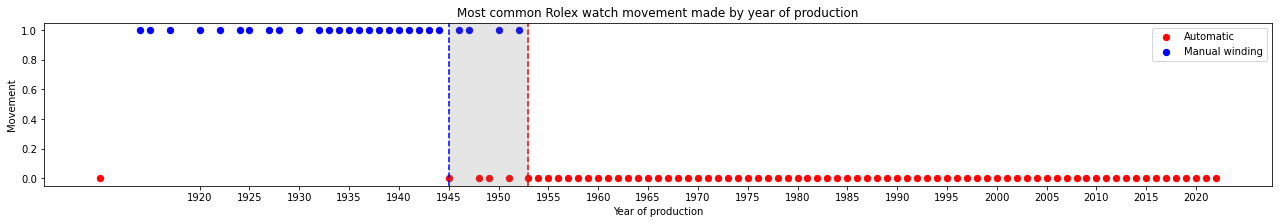

In [20]:
ax = plt.subplots(figsize=(22, 3))
scp1 = plt.scatter(res_mmdf_plot1['year of production'], res_mmdf_plot1['movement'], s=40, c='red', label='Automatic')
scp2 = plt.scatter(res_mmdf_plot2['year of production'], res_mmdf_plot2['movement'], s=40, c='blue', label='Manual winding')

plt.legend(handles=[scp1, scp2])
plt.title('Most common Rolex watch movement made by year of production')
plt.xlabel('Year of production')
plt.ylabel('Movement')

# two vertical lines to make it easier to see 
plt.axvline(x=1945, color='b', linestyle='--')
plt.axvline(x=1953, color='r', linestyle='--')
plt.axvspan(1945, 1953, alpha=0.2, color='grey')

plt.xticks(np.arange(1920, 2022, 5))

plt.show()

- We decide to use scatter plot to visualize the data as each every dot represents a movement (0 is Automatic, 1 is Manual winding, 2 is supposed to be Quatz but according to the data, it has never been common in Rolex watches)
- We will draw two lines to show the change of trend in Rolex watches movement (1945 - 1953) - the period of time show that the customers and Rolex were starting to change from Manual to Automatic.
  
  - The blue line is when trend starts to change from Manual to Automatic
  - The red line is when Automatic becomes the most common movement

So how the movement change in 1945 - 1953 ?
 - We will visualize that interval in details for better understanding

Prepare the data from 1940 to 1960 to visualize

In [21]:
ptc = mmgb.copy()
ptca = ptc[(ptc['year of production'] <= 1960) & (ptc['year of production'] >= 1940) & (ptc['movement'] == 'Automatic')]
ptcm = ptc[(ptc['year of production'] <= 1960) & (ptc['year of production'] >= 1940) & (ptc['movement'] == 'Manual winding')]
ptcq = ptc[(ptc['year of production'] <= 1960) & (ptc['year of production'] >= 1940) & (ptc['movement'] == 'Quartz')]

Visualize the data

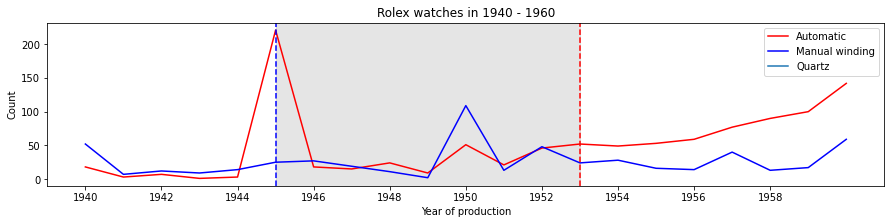

In [22]:
ax = ptca.plot(x='year of production', y='count', label='Automatic', figsize=(15, 3), color='red')
ptcm.plot(x='year of production', y='count', label='Manual winding', color='blue', ax=ax)
ptcq.plot(x='year of production', y='count', label='Quartz', ax=ax)
plt.title('Rolex watches in 1940 - 1960')
plt.xlabel('Year of production')
plt.ylabel('Count')

plt.axvline(x=1945, color='b', linestyle='--')
plt.axvline(x=1953, color='r', linestyle='--')
plt.axvspan(1945, 1953, alpha=0.2, color='grey')

plt.xticks(np.arange(1940, 1960, 2))

plt.show()

- We can see that in that interval, the number of Manual winding (blue) watches is decreasing and the number of Automatic (red) watches is increasing (of course, there are still up and down in the mean time but in the end - 1953 they decided to go with Automatic)

#### Conclusion a
. 1920 - 1945 : Manual winding is the most common movement in Rolex watches \
. 1945 - 1953 : Bovement changing from Manual to Automatic \
. 1953 - now : Automatic is the most common movement in Rolex watches

### b. How Rolex `case material` changes ?

A quick preview of the data before we start

In [23]:
q2df.sort_values(by=['year of production'], ascending=False)

,model,movement,case material,case diameter,year of production
43560,Rolex Datejust,Automatic,White gold,36,2022.0
33261,Rolex Yacht-Master,Automatic,Steel,40,2022.0
33245,Rolex Oyster Perpetual,Automatic,Steel,33,2022.0
33246,Rolex GMT-Master II,Automatic,Steel,40,2022.0
67751,Rolex Oyster Perpetual,Automatic,Steel,36,2022.0
...,...,...,...,...,...
67147,Rolex,Manual winding,Silver,34,1914.0
3369,Rolex,Manual winding,Silver,34,1914.0
4729,Rolex,Manual winding,Silver,32,1914.0
60685,Rolex,Manual winding,Silver,32,1914.0


Group by year and case material to get the number of each case material in each year

In [24]:
cmgb = q2df.groupby(
    ['year of production', 'case material']).count()
cmgb

model  movement  case diameter
year of production case material                                
1910.0             Steel              1         1              1
1914.0             Silver             4         4              4
1915.0             Rose gold          3         3              3
                   Silver             2         2              2
1917.0             Silver             2         2              2
...                                 ...       ...            ...
2022.0             Silver            55        55             55
                   Steel          21240     21240          21240
                   Titanium           7         7              7
                   White gold      2332      2332           2332
                   Yellow gold     4028      4028           4028

[535 rows x 3 columns]

Extract the features and rename the columns

In [25]:
cmgb=cmgb.reset_index()
cmgb=cmgb.loc[:, ['year of production', 'case material', 'model']].rename(columns={'model': 'count'})

Get the most common case material for each year of production

In [26]:
res_cm = cmgb.sort_values(
    by=['year of production', 'count'],
    ascending=[True, False]).drop_duplicates(
        subset=['year of production'],
        keep='first')

Get a list to store all the case materials

In [27]:
material_list = tt['case material'].unique()
material_list

array(['Steel', 'White gold', 'Gold/Steel', 'Yellow gold', 'Rose gold',
       'Platinum', 'Silver', 'Red gold', 'Ceramic', 'Bronze', 'Carbon',
       'Titanium', 'Aluminum'], dtype=object)

Get all available case materials appeared in res_cm (Most common case materials for each year)

In [28]:
a_material_list = [m for m in material_list if res_cm.loc[res_cm['case material'] == m].shape[0] != 0]
a_material_list

['Steel', 'Gold/Steel', 'Yellow gold', 'Rose gold', 'Silver']

Prepare the data for visualizing

In [29]:
res_cm_plot = res_cm.copy()
for m in a_material_list:
    res_cm_plot['case material'] = res_cm_plot['case material'].replace(m, a_material_list.index(m))

res_cm_plot1 = res_cm_plot[res_cm_plot['case material'] == 0]
res_cm_plot2 = res_cm_plot[res_cm_plot['case material'] == 1]
res_cm_plot3 = res_cm_plot[res_cm_plot['case material'] == 2]


#### How many watches of each case material made in each year to be the most common ?

As the Steel material appears to be the most common case material of all time, so this bar plot should be a very long one so we will be visualized in a different way

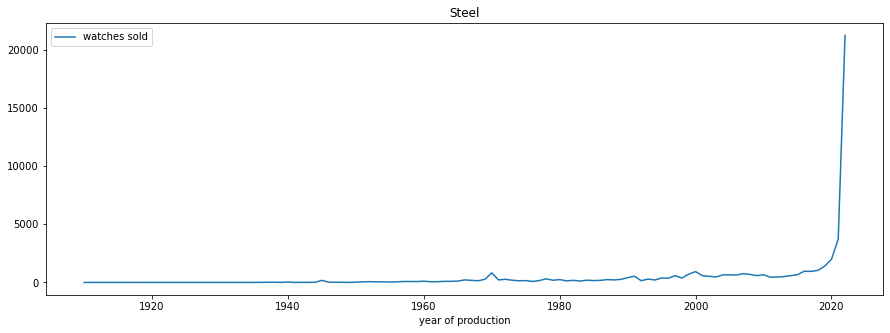

In [30]:
# Steel
res_cm_plot1.plot(x = 'year of production', y = 'count', label='watches sold', title='Steel', figsize=(15, 5))
plt.legend()
plt.show()

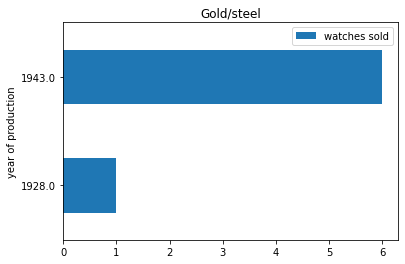

In [31]:
# Gold/steel
res_cm_plot2.plot(x = 'year of production', y = 'count', kind='barh', label='watches sold', title='Gold/steel')
plt.show()

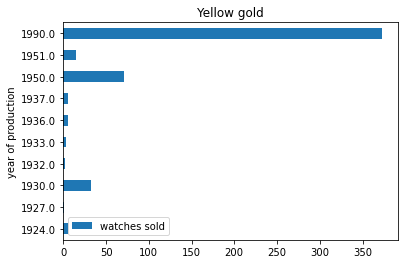

In [32]:
# Yellow gold
res_cm_plot3.plot(x = 'year of production', y = 'count', kind='barh', label='watches sold', title='Yellow gold')
plt.show()

#### Visualize the data

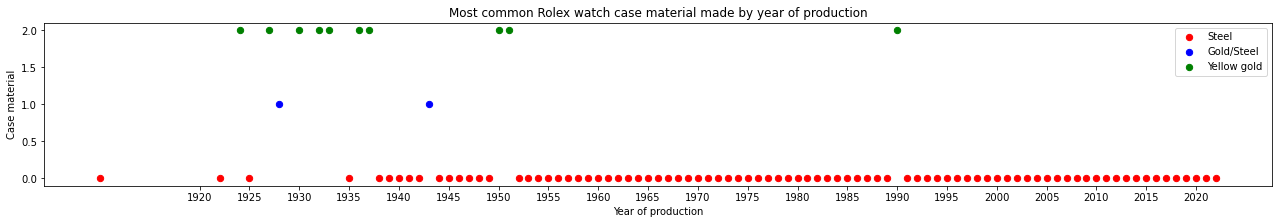

In [33]:
ax = plt.subplots(figsize=(22, 3))
scp1 = plt.scatter(res_cm_plot1['year of production'], res_cm_plot1['case material'], s=40, c='red', label='Steel')
scp2 = plt.scatter(res_cm_plot2['year of production'], res_cm_plot2['case material'], s=40, c='blue', label='Gold/Steel')
scp3 = plt.scatter(res_cm_plot3['year of production'], res_cm_plot3['case material'], s=40, c='green', label='Yellow gold')

plt.legend(handles=[scp1, scp2, scp3])
plt.title('Most common Rolex watch case material made by year of production')
plt.xlabel('Year of production')
plt.ylabel('Case material')

plt.xticks(np.arange(1920, 2022, 5))
plt.show()

#### Conclusion b
- Steel is the most common case material in Rolex watches from 1920 to now
- There were some changes in the case material of Rolex watches in the past but it is not significant enough to be noticed

### Conclusion
- The most common case material of Rolex watches is Steel from 1920 to now
- Rolex changed their strategy to satisfy the needs of their customers
  - In this case, they have to change their movement from Manual to Automatic to satisfy the needs of their customers
- So if there's nothing changes in the future like Rolex come up a very inovative watches movement or case material, We can assume that in the next years, the majority of Rolex watches sold on the market will be made of Steel and have Automatic movement.

- By answering this question
  - We can know that Rolex is similar to any other business, they have to change their strategy to satisfy the needs of their customers. Before this we thought that Rolex is very much of a traditional company and they would never change their strategy
  - We can know that in the future, the majority of Rolex watches sold on the market will be made of Steel and have Automatic movement.